In [1]:
from sklearn import decomposition
from sklearn import datasets
import sklearn
import hummingbird.ml as hb
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skl2onnx import to_onnx
import onnxruntime as rt

/Users/AlibiZhenis/PycharmProjects/opensearch-ml/venv/lib/python3.9/site-packages/skl2onnx/algebra/onnx_ops.py:159: UserWarning: OpSchema.FormalParameter.typeStr is deprecated and will be removed in 1.16. Use OpSchema.FormalParameter.type_str instead.
  tys = obj.typeStr or ''
/Users/AlibiZhenis/PycharmProjects/opensearch-ml/venv/lib/python3.9/site-packages/skl2onnx/algebra/automation.py:154: UserWarning: OpSchema.FormalParameter.isHomogeneous is deprecated and will be removed in 1.16. Use OpSchema.FormalParameter.is_homogeneous instead.
  if getattr(obj, 'isHomogeneous', False):
/Users/AlibiZhenis/PycharmProjects/opensearch-ml/venv/lib/python3.9/site-packages/jinja2/environment.py:485: UserWarning: OpSchema.FormalParameter.typeStr is deprecated and will be removed in 1.16. Use OpSchema.FormalParameter.type_str instead.
  return getattr(obj, attribute)


In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
random_state = 0

# Loading breast cancer wisconsin dataset

In [3]:
X, y = datasets.load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, 
                                      test_size=0.3, random_state=random_state)

# Initializing and fitting the models

In [4]:
RF = RandomForestClassifier(random_state = random_state, max_depth=10)
SVC = LinearSVC(random_state = random_state)
KNN = KNeighborsClassifier()
sklearn_models = [RF, SVC, KNN]

In [5]:
for model in sklearn_models:
    model.fit(X_train, y_train)

/Users/AlibiZhenis/PycharmProjects/opensearch-ml/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


# Convert the models to torchscript using Hummingbird and test the results (visualized further below)

RandomForest and LinearSVC

In [6]:
torch_models = []
for model in sklearn_models[:2]:
    torch_model = hb.convert(model, "TorchScript", 
                             test_input = np.array(X_train[0]).reshape(1, -1))
    torch_models.append(torch_model)

K Nearest Neighbors

In [8]:
extra_config = {hb.operator_converters.constants.BATCH_SIZE: 1}
knn = hb.convert_batch(sklearn_models[2], "TorchScript", 
                         test_input = np.array(X_train[0]).reshape(1, -1),
                         extra_config=extra_config)
torch_models.append(knn)

In [9]:
sklearn_scores = []
for model in sklearn_models:
    y_pred = model.predict(X_test)
    res = {
        "accuracy": sklearn.metrics.accuracy_score(y_test, y_pred),
        "precision": sklearn.metrics.precision_score(y_test, y_pred),
        "recall": sklearn.metrics.recall_score(y_test, y_pred)
    }
    sklearn_scores.append(res)

In [10]:
torch_scores = []
for model in torch_models:
    y_pred = model.predict(X_test)
    res = {
        "accuracy": sklearn.metrics.accuracy_score(y_test, y_pred),
        "precision": sklearn.metrics.precision_score(y_test, y_pred),
        "recall": sklearn.metrics.recall_score(y_test, y_pred)
    }
    torch_scores.append(res)

# Convert the models to ONNX using skl2onnx and test the results (visualized further below)

In [11]:
onnx_models = []
for model in sklearn_models:
    onnx_model = to_onnx(model, X = X_train.astype(np.float32))
    onnx_models.append(onnx_model)

In [12]:
onnx_scores = []
for model in onnx_models:
    sess = rt.InferenceSession(model.SerializeToString())
    input_name = sess.get_inputs()[0].name
    label_name = sess.get_outputs()[0].name
    y_pred = sess.run([label_name], {input_name: X_test.astype(np.float32)})[0]
    
    res = {
        "accuracy": sklearn.metrics.accuracy_score(y_test, y_pred),
        "precision": sklearn.metrics.precision_score(y_test, y_pred),
        "recall": sklearn.metrics.recall_score(y_test, y_pred)
    }
    onnx_scores.append(res)

# Visualizing inference results

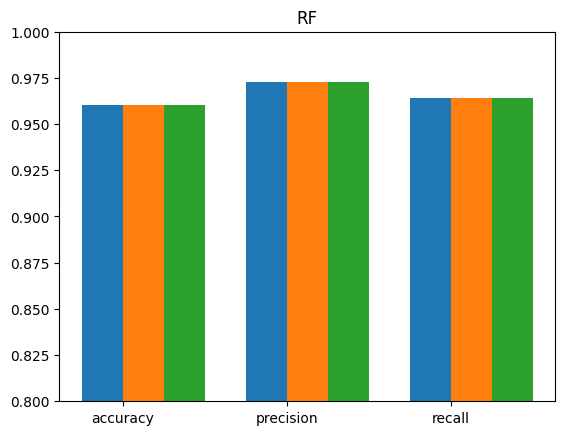

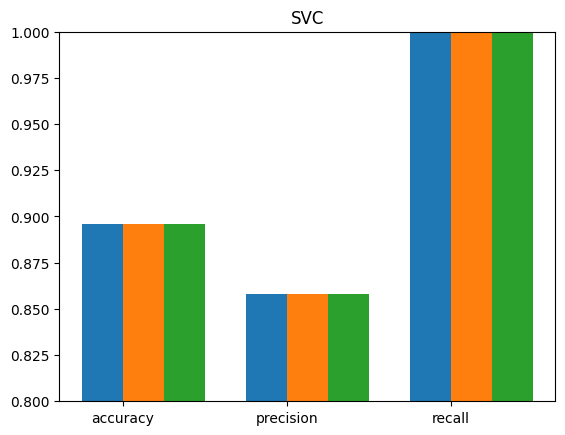

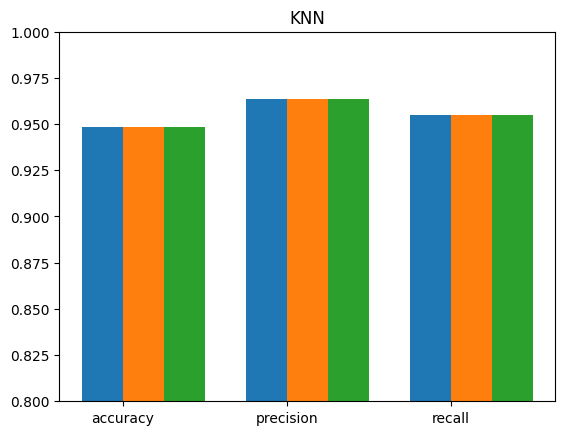

In [13]:
for i, model in enumerate(["RF", "SVC", "KNN"]):
    data = (
        (sklearn_scores[i]["accuracy"], torch_scores[i]["accuracy"], onnx_scores[i]["accuracy"]), 
        (sklearn_scores[i]["precision"], torch_scores[i]["precision"], onnx_scores[i]["precision"]), 
        (sklearn_scores[i]["recall"], torch_scores[i]["recall"], onnx_scores[i]["recall"])
    )
    dim = len(data[0])
    w = 0.75
    dimw = w / dim
    
    fig, ax = plt.subplots()
    plt.title(model)
    x = np.arange(len(data))
    for i in range(len(data[0])):
        y = [d[i] for d in data]
        b = ax.bar(x + i * dimw, y, dimw, bottom=0.001)

    ax.set_xticks(x + dimw / 2, labels=["accuracy", "precision", "recall"])
    plt.ylim(0.8, 1)
    plt.show()

# Conclusion

All three classifiers and their converted versions produce identical results.
